<a href="https://colab.research.google.com/github/MurphLaws/Exp/blob/main/scatter_ECDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt, cm, colors
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import pandas as pd
from itertools import chain
import itertools
from __future__ import absolute_import, division, print_function
import tensorflow as tf
from sklearn.model_selection import train_test_split
from operator import itemgetter
tf.autograph.set_verbosity(0)
from tqdm import tqdm
import os
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from scipy.interpolate import bisplrep, bisplev
from scipy.ndimage import gaussian_filter
from collections import namedtuple
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from itertools import compress
import seaborn as sns
from matplotlib.lines import Line2D


,X1,X2,Label
0,-0.001461,-0.657357,0.0
1,0.480067,-2.240576,0.0
2,-0.048678,-0.573525,0.0
3,1.519183,-1.040114,0.0
4,0.038773,1.612674,0.0


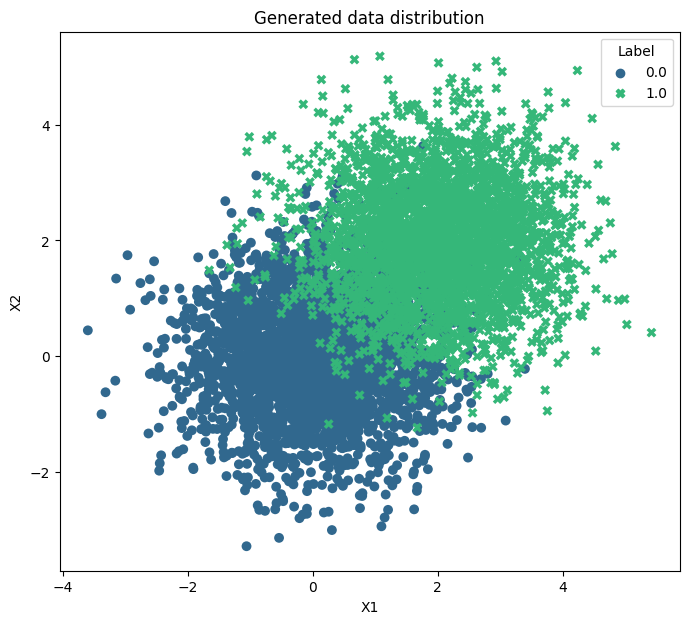

In [2]:
random.seed(2349324)
np.random.seed(2349324)
tf.random.set_seed(2349324)


# Create dataset composed of teo points clusters with generated with a bivariate gaussian distribution with mean [0,0] and [4,4]
# and equal covariance matrices.

def create_data(n):
    mean1 = [0,0]
    covmat = [[1, 0], [0, 1]]
    cov  = covmat
    x1_1, x2_1 = np.random.multivariate_normal(mean1, cov, int(n/2)).T

    mean2 = [2,2]
    cov  = covmat
    x1_2, x2_2 = np.random.multivariate_normal(mean2, cov, int(n/2)).T

    pts1 = list(zip(x1_1, x2_1,itertools.repeat(0)))
    pts2 = list(zip(x1_2, x2_2,itertools.repeat(1)))

    return pd.DataFrame(np.concatenate((pts1,pts2),axis=0), columns = ["X1", "X2", "Label"])


interleaved  = create_data(6000)


plt.figure(figsize=(8,7))
sns.scatterplot(data=interleaved, x='X1', y='X2', hue='Label', palette='viridis', style='Label',s=50, linewidth=0).set(title = 'Generated data distribution')
interleaved.head()

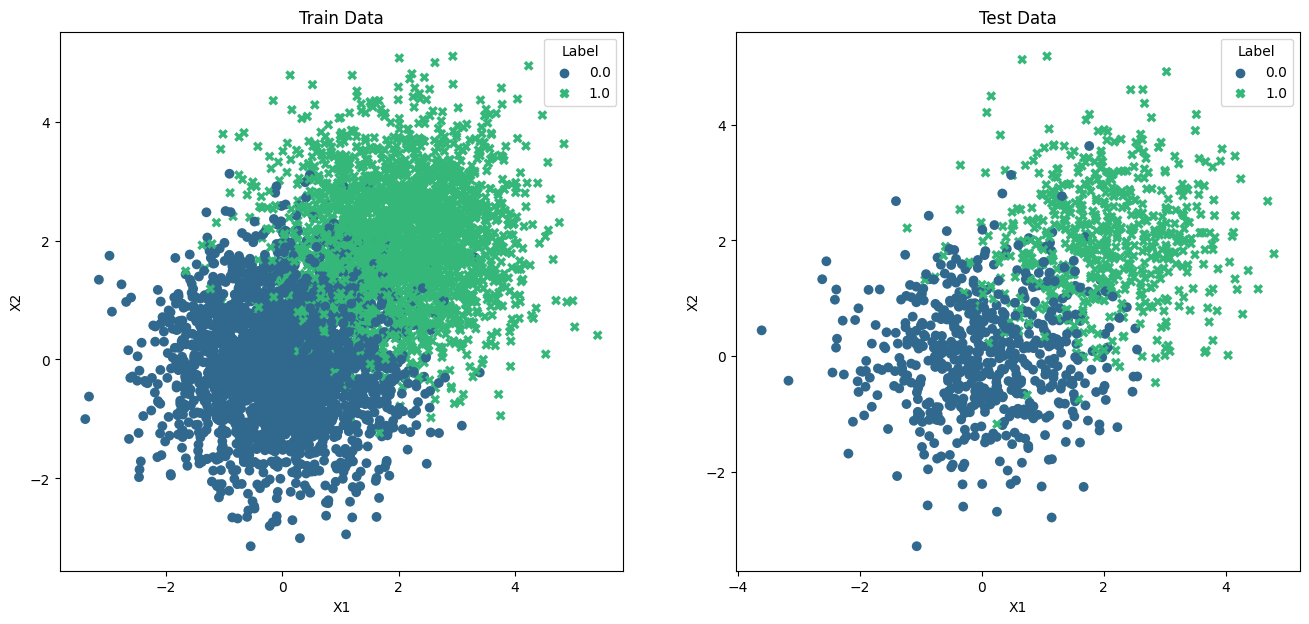

In [3]:

#I created this namedtuple in order to acces more easily to the Test and Train data for each of the Leave One Out Datasets
Data = namedtuple('Data', ['x_train','x_test','y_train','y_test'])



#The Data namedtuple is used here, to take a DF of data, and split it into x_train, y_train, x_test and y_test.
def split(df, size = 0.2):
    x = df[['X1','X2']]
    y = df['Label']

    if size > 0:
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=size, random_state=2349324)
        return Data(x_train = x_train,x_test=x_test,y_train = y_train,y_test=y_test)

    else:
        return Data(x_train=x, y_train=y, x_test = x_test, y_test = y_test)



def binary_cross_entropy(predictions, probabilities):
    binary_crossentropy = []
    for i in range(len(predictions)):
        b = predictions[i]
        p = probabilities[i][1]  # Assuming the probability of the positive class is at index 1

        # Calculate the binary crossentropy
        cross_entropy = -b * np.log(p) - (1 - b) * np.log(1 - p)
        binary_crossentropy.append(cross_entropy)

    return binary_crossentropy



#This funcions receives a Data namedtuple and train a new LogReg model, with initialized weights and returns an array of the
# Unaggregated Loss of all the test points
def train_predict(data):

    np.random.seed(2349324)


    fan_avg = (data.x_train.shape[1] + 1) / 2  # Average of input and output dimensions
    limit = np.sqrt(6 / fan_avg)
    weights_init = np.random.uniform(low=-limit, high=limit, size=(data.x_train.shape[1],))

    logreg = LogisticRegression(solver='liblinear', random_state=2349324)
    logreg.coef_ = weights_init.reshape(1, -1)


    logreg.fit(data.x_train, data.y_train)

    y_pred  = logreg.predict(data.x_test)
    y_proba = logreg.predict_proba(data.x_test)

    return binary_cross_entropy(list(data.y_test), y_proba)



#This function takes a DF and returns a list of tuples, each tuple is (index of removed element, DF with said element removed)
def leave_one_out(df, inf_type="individual", n=1):

    loo_dfs = []
    if inf_type=='individual':
        for i in df.index:
            loo_dfs.append((i,df.drop([i])))

    if inf_type=='group':
        for i in df.index:
            datapoints_to_remove = (random.sample(list(df.index), n))
            loo_dfs.append((datapoints_to_remove,df.drop(datapoints_to_remove)))

    return loo_dfs




def remove_element_by_index(lst, index):
    return lst[:index] + lst[index+1:]


#Here we have a code for a similiar function to train_predict, that return y_pred and y_proba from a Data namedtuple

def pred_and_prob(data):
    fan_avg = (data.x_train.shape[1] + 1) / 2  # Average of input and output dimensions
    limit = np.sqrt(6 / fan_avg)
    weights_init = np.random.uniform(low=-limit, high=limit, size=(data.x_train.shape[1],))

    logreg = LogisticRegression(solver='liblinear', random_state=2349324)
    logreg.coef_ = weights_init.reshape(1, -1)

    logreg.fit(data.x_train, data.y_train)

    y_pred  = logreg.predict(data.x_test)
    y_proba = logreg.predict_proba(data.x_test)

    return y_pred, y_proba



graph_data = split(interleaved)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

sns.scatterplot(x=graph_data.x_train['X1'], y=graph_data.x_train['X2'], hue=graph_data.y_train, palette='viridis', style=graph_data.y_train, s=50, ax=axes[0],linewidth = 0)
axes[0].set_title('Train Data')

sns.scatterplot(x=graph_data.x_test['X1'], y=graph_data.x_test['X2'], hue=graph_data.y_test, palette='viridis', style=graph_data.y_test, s=50, ax=axes[1],linewidth = 0)
axes[1].set_title('Test Data')

# plt.tight_layout()

plt.show()







<a href="https://imgur.com/Cm3C8rX"><img src="https://i.imgur.com/Cm3C8rX.png" title="source: imgur.com" /></a>

In [4]:




# Getting Self Influence is different from other signal, cause we don't have the conventional influence_matrix, so we create it's own function


def run_SI(df):

    full_loss = train_predict(split(df))


    influences = []
    datasets = leave_one_out(df)

    for ds in tqdm(datasets):
        data = Data(x_train = ds[1][['X1','X2']], y_train = ds[1]['Label'], x_test = pd.DataFrame(df.iloc[ds[0]]).T[['X1','X2']], y_test = pd.DataFrame(df.iloc[ds[0]]).T['Label'])
        y_pred,y_proba = pred_and_prob(data)
        influences.append((binary_cross_entropy(list(data.y_test), y_proba)-np.mean(full_loss))[0])

    new_df = df
    new_df['Influence'] = influences
    return new_df


interleaved  = create_data(500)





#And now we have the influence matrix code, which computes the full loss by doing split on the full data, and then saves the test.
#After that, we apply leave one out to the resulting train and use pred_and_prob with each new dataset.

def influence_matrix(df):
    influences = []
    shared = split(df)
    shr_x_train = shared.x_train
    shr_y_train = shared.y_train
    shr_x_test  = shared.x_test
    shr_y_test  = shared.y_test

    full_loss = train_predict(Data(x_train = shr_x_train, y_train= shr_y_train, x_test = shr_x_test, y_test = shr_y_test))
    datasets = leave_one_out(shr_x_train)
    inf_matrix = pd.DataFrame(0, index=list(shr_x_train.index), columns=list(shr_x_test.index))

    for ds in tqdm(datasets):
        data = Data(x_train = ds[1], y_train= shr_y_train.drop(ds[0]), x_test = shr_x_test, y_test = shr_y_test)
        y_pred,y_proba = pred_and_prob(data)
        influences.append((binary_cross_entropy(list(data.y_test), y_proba)-np.array(full_loss)))
        inf_matrix.loc[ds[0]] = (binary_cross_entropy(list(data.y_test), y_proba)-np.array(full_loss))

    if inf_matrix.index.duplicated().any():

        #We delete duplicates on the influence matrix (I know I can't have, just in case :)
        inf_matrix = inf_matrix[~df.index.duplicated(keep='first')]

    return inf_matrix




In [5]:



# This is the different aggregations corresponding to each Influence Error Signal

def run_MPI(matrix):
    new_df = matrix.mask(matrix < 0, 0)
    new_df['Influence'] = new_df.sum(axis=1)
    return new_df[['Influence']]

def run_MSPI(matrix):
    class_df = matrix.mask(matrix < 0, 0).mask(matrix > 0, 1)
    class_df['Influence'] = class_df.sum(axis=1)
    return  class_df['Influence']

def run_MSNI(matrix):
    class_df = matrix.mask(matrix > 0, 0).mask(matrix < 0, 1)
    class_df['Influence'] = class_df.sum(axis=1)
    return  class_df['Influence']

def run_MNI(matrix):
    new_df = matrix.mask(matrix > 0, 0)
    new_df['Influence'] = new_df.sum(axis=1)*-1
    return new_df[['Influence']]

def run_MAI(matrix):
    new_df = matrix.abs()
    new_df['Influence'] = new_df.sum(axis=1)
    return new_df[['Influence']]

def retrieve(original, result):
    return original.join(result).dropna()


def run_PIL(df, matrix, class_label):
    transposed = matrix.T.join(df).drop(['X1','X2'],axis=1)
    new_df = transposed[transposed['Label'] == class_label].drop('Label', axis=1).T
    return run_MPI(new_df)


def run_NIL(df, matrix, class_label):
    transposed = matrix.T.join(df).drop(['X1','X2'],axis=1)
    new_df = transposed[transposed['Label'] == class_label].drop('Label', axis=1).T
    return run_MNI(new_df)


def run_AIL(df, matrix, class_label):
    transposed = matrix.T.join(df).drop(['X1','X2'],axis=1)
    new_df = transposed[transposed['Label'] == class_label].drop('Label', axis=1).T
    return run_MAI(new_df)


def run_SLIP(df, matrix, class_label):

    transposed = matrix.T.join(df).drop(['X1','X2'],axis=1)
    new_df = transposed[transposed['Label'] == class_label].drop('Label', axis=1).T
    class_df = new_df.mask(new_df < 0, 0).mask(new_df > 0, 1)
    class_df['Influence'] = class_df.sum(axis=1)

    return class_df[['Influence']]



def run_SLIN(df, matrix, class_label):

    transposed = matrix.T.join(df).drop(['X1','X2'],axis=1)
    new_df = transposed[transposed['Label'] == class_label].drop('Label', axis=1).T
    class_df = new_df.mask(new_df < 0, 1).mask(new_df > 0, 0)
    class_df['Influence'] = class_df.sum(axis=1)

    return class_df[['Influence']]






In [6]:



DATA = create_data(6000)

im = influence_matrix(DATA)


# print(DATA.columns)

# ### SELF INFLUENCE
# SI = run_SI(DATA).sort_values('Influence')


### MARGINAL SIGNALS

# MPI = retrieve(DATA,run_MPI(im)).sort_values('Influence')
# MNI = retrieve(DATA,run_MNI(im)).sort_values('Influence')
# MAI = retrieve(DATA,run_MAI(im)).sort_values('Influence')
# MSPI = retrieve(DATA,run_MSPI(im)).sort_values('Influence', ascending = False)
# MSNI = retrieve(DATA,run_MSNI(im)).sort_values('Influence')


# ## CONDITIONAL SIGNALS


# PIL0  = retrieve(DATA,run_PIL(DATA, im, 0)).sort_values('Influence')
# PIL1  = retrieve(DATA,run_PIL(DATA, im, 1)).sort_values('Influence')
# NIL0  = retrieve(DATA,run_NIL(DATA, im, 0)).sort_values('Influence')
# NIL1  = retrieve(DATA,run_NIL(DATA, im, 1)).sort_values('Influence')
# AIL0  = retrieve(DATA,run_AIL(DATA, im, 0)).sort_values('Influence')
# AIL1  = retrieve(DATA,run_AIL(DATA, im, 1)).sort_values('Influence')
# SLIP0 = retrieve(DATA,run_SLIP(DATA, im, 0)).sort_values('Influence', ascending = False)
# SLIP1 = retrieve(DATA,run_SLIP(DATA, im, 1)).sort_values('Influence', ascending = False)
# SLIN0 = retrieve(DATA,run_SLIN(DATA, im, 0)).sort_values('Influence')
# SLIN1 = retrieve(DATA,run_SLIN(DATA, im, 1)).sort_values('Influence')



def plot_signal(df, title):
    plt.figure(figsize=(8, 6))
    kwargs = {'edgecolor': "black", 'linewidth': 0}
    sp = sns.scatterplot(data=df, x='X1', y='X2', hue='Influence', legend='brief', style='Label', palette='viridis', s=60, **kwargs)
    sp.get_legend().remove()

    custom_handles = [
        plt.scatter([], [], marker='o', s=80, color='black', label='0'),
        plt.scatter([], [], marker='x', s=80, color='black', label='1'),
    ]

    plt.legend(handles=custom_handles, title='Label')

    norm = plt.Normalize(df['Influence'].min(), df['Influence'].max())
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sp.figure.colorbar(sm, ax=sp)
    sp.set(title=title)
    plt.show()


# plot_signal(SI, "Self Influence")
# plot_signal(MPI,"Marginal Positive Influence")
# plot_signal(MNI,"Marginal Negative Influence")
# plot_signal(MAI,"Marginal Absolute Influence")
# plot_signal(MSPI, "# of samples Positively influenced Marginally")
# plot_signal(MSNI, "# of samples Negatively influenced Marginally")

# plot_signal(PIL0,"Positive influence on Class 0")
# plot_signal(PIL1,"Positive influence on Class 1")
# plot_signal(NIL0,"Negative influence on Class 0")
# plot_signal(NIL1,"Negative influence on Class 1")
# plot_signal(AIL0,"Absolute influence on Class 0")
# plot_signal(AIL1,"Absolute influence on Class 1")
# plot_signal(SLIP0,"# of samples Positively Influenced on Class 0")
# plot_signal(SLIP1,"# of samples Positively influenced on Class 1")
# plot_signal(SLIN0,"# of samples Negatively influenced on Class 0")
# plot_signal(SLIN1,"# of samples Negatively influenced on Class 1")





100%|██████████| 4800/4800 [05:12<00:00, 15.34it/s]



# Self Influence
<a href="https://imgur.com/P4a4FJY"><img src="https://i.imgur.com/P4a4FJY.png" width="400" title="source: imgur.com" /></a>

# Marginal Signals

<a href="https://imgur.com/ecdFDYJ"><img src="https://i.imgur.com/ecdFDYJ.png"   width="400"  title="source: imgur.com" /></a>
<a href="https://imgur.com/T8JODYS"><img src="https://i.imgur.com/T8JODYS.png"  width="400"  title="source: imgur.com" /></a>
<a href="https://imgur.com/SgCJYfr"><img src="https://i.imgur.com/SgCJYfr.png" width="400" title="source: imgur.com" /></a>
<br>
<a href="https://imgur.com/SgCJYfr"><img src="https://i.imgur.com/tUxyKvj.png" width="400" title="source: imgur.com" /></a>
<a href="https://imgur.com/SgCJYfr"><img src="https://i.imgur.com/IbygtzR.png" width="400" title="source: imgur.com" /></a>

#Conditional Signals

<a href="https://imgur.com/ecdFDYJ"><img src="https://i.imgur.com/sPIcGYr.png"   width="400"  title="source: imgur.com" /></a>
<a href="https://imgur.com/T8JODYS"><img src="https://i.imgur.com/YmGyl6f.png"  width="400"  title="source: imgur.com" /></a>
<a href="https://imgur.com/SgCJYfr"><img src="https://i.imgur.com/eQiftO9.png" width="400" title="source: imgur.com" /></a>
<a href="https://imgur.com/SgCJYfr"><img src="https://i.imgur.com/TmTilxv.png" width="400" title="source: imgur.com" /></a>

<a href="https://imgur.com/SgCJYfr"><img src="https://i.imgur.com/tagK1Kf.png" width="400" title="source: imgur.com" /></a>
<a href="https://imgur.com/SgCJYfr"><img src="https://i.imgur.com/UNfTjsF.png" width="400" title="source: imgur.com" /></a>


<a href="https://imgur.com/SgCJYfr"><img src="https://i.imgur.com/Be9jvvJ.png" width="400" title="source: imgur.com" /></a>
<a href="https://imgur.com/SgCJYfr"><img src="https://i.imgur.com/wNbJukU.png" width="400" title="source: imgur.com" /></a>

<a href="https://imgur.com/SgCJYfr"><img src="https://i.imgur.com/pK03EaH.png" width="400" title="source: imgur.com" /></a>
<a href="https://imgur.com/SgCJYfr"><img src="https://i.imgur.com/bXkN4f6.png" width="400" title="source: imgur.com" /></a>



In [7]:

def group_influence_matrix(df, n):
    influences = []
    shared = split(df)
    shr_x_train = shared.x_train
    shr_y_train = shared.y_train
    shr_x_test  = shared.x_test
    shr_y_test  = shared.y_test

    full_loss = train_predict(Data(x_train = shr_x_train, y_train= shr_y_train, x_test = shr_x_test, y_test = shr_y_test))
    datasets = leave_one_out(shr_x_train, inf_type='group', n=n)
    groups = [str(loo[0]) for loo in datasets]

    str_id_data = [((str(loo[0])),loo[1]) for loo in datasets]

    inf_matrix = pd.DataFrame(0, index=groups, columns=list(shr_x_test.index))


    for ds in tqdm(datasets):
        data = Data(x_train = ds[1], y_train= shr_y_train.drop(ds[0]), x_test = shr_x_test, y_test = shr_y_test)
        y_pred,y_proba = pred_and_prob(data)
        influences.append((binary_cross_entropy(list(data.y_test), y_proba)-np.array(full_loss)))
        inf_matrix.loc[str(ds[0])] = (binary_cross_entropy(list(data.y_test), y_proba)-np.array(full_loss))

    if inf_matrix.index.duplicated().any():
        inf_matrix = inf_matrix[~inf_matrix.index.duplicated(keep='first')]


    return inf_matrix


group_influence_matrix(create_data(50), 3).head(5)

100%|██████████| 40/40 [00:00<00:00, 217.18it/s]


,0,19,10,35,2,49,23,21,26,13
"[25, 4, 34]",0.002597,0.000853,0.003023,0.029348,-0.014547,0.028613,0.004004,0.003337,0.002158,-0.010225
"[14, 3, 6]",0.008261,0.022219,0.013623,-0.007676,0.033314,-0.014900,0.011905,0.015075,0.001215,0.030702
"[44, 27, 1]",0.002294,0.002687,0.005990,-0.006473,0.014620,-0.045415,0.016040,0.023583,-0.000403,0.017640
"[42, 32, 5]",0.003051,0.006747,0.004393,0.007610,0.003764,0.010330,0.003037,0.002921,0.001105,0.003993
"[9, 12, 15]",0.010555,0.025168,0.019337,-0.014040,0.047109,-0.052193,0.026151,0.035647,0.000782,0.046872


In [8]:

def aggregate_ind(ind_matrix, group_matrix):
    sum_array = []
    aggregate_matrix = pd.DataFrame(0, index=group_matrix.index, columns=group_matrix.columns)
    for index in tqdm(group_matrix.index):
        sum = 0
        for indv in eval(index):
            sum+=np.array(ind_matrix.loc[indv])
        aggregate_matrix.loc[index] = sum
    return aggregate_matrix




In [9]:
from scipy.stats import spearmanr
from statsmodels.distributions.empirical_distribution import ECDF


def ecdf(influence_matrix_1, influence_matrix_2):
    assert influence_matrix_1.shape == influence_matrix_2.shape

    # The function assumes that rows represent the train sample ids and
    # columns the test sample ids. The correlations are computed column-wise.
    # This is because this structure implies the many-to-one relation, i.e., many train examples (or groups)
    # to one test example

    corr_vals = {}
    #p_value_threshold = 0.05

    for col in influence_matrix_1.columns:
        spearman_r, pval = spearmanr(
            influence_matrix_1.loc[:, col], influence_matrix_2.loc[:, col]
        )
        #if pval <= p_value_threshold:
        corr_vals[col] = spearman_r
    print(
        "Statistically significant in rows count:",
        len(corr_vals) / influence_matrix_1.shape[1],
    )
    return ECDF(list(corr_vals.values()))


# def plot_ecdf(ecdf_arr):
#     data, ecdf =
#     pass

def plot_ecdf(ecdf_obj,title):
    # Convert ECDF object to Pandas DataFrame
    df = pd.DataFrame({'x': ecdf_obj.x, 'y': ecdf_obj.y})

    # Plot ECDF using Seaborn
    sns.ecdfplot(data=df, x='x')
    plt.xlabel('X')
    plt.ylabel('ECDF')
    plt.title(title)
    plt.grid(True)
    plt.show()







100%|██████████| 4797/4797 [03:39<00:00, 21.90it/s]


Statistically significant in rows count: 1.0


100%|██████████| 4800/4800 [03:58<00:00, 20.10it/s]


Statistically significant in rows count: 1.0


100%|██████████| 4800/4800 [04:19<00:00, 18.52it/s]


Statistically significant in rows count: 1.0


<ipython-input-10-a926fb3e634c>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().xaxis.set_major_formatter(FixedFormatter(['{:0.5f}'.format(x) for x in plt.gca().get_xticks()]))


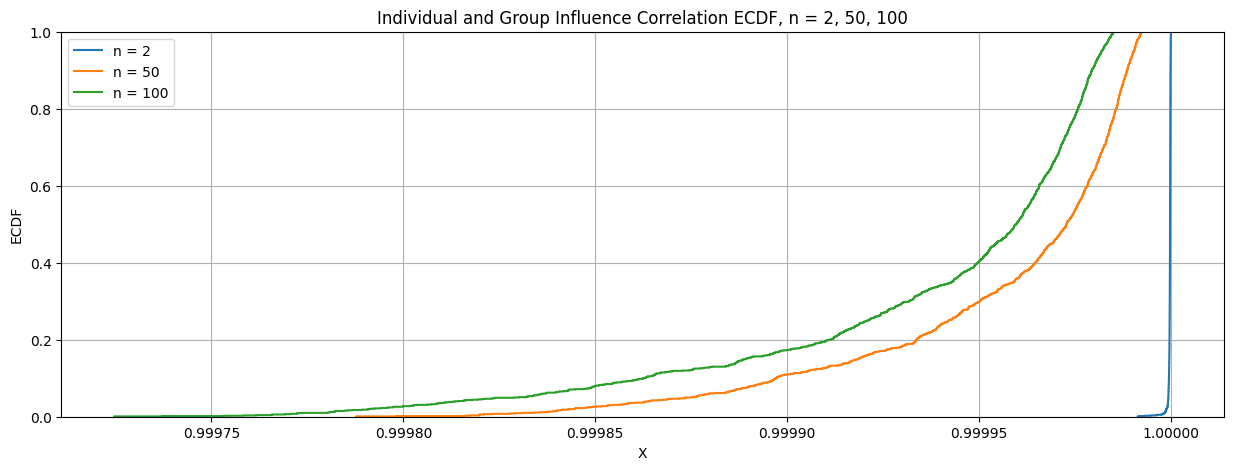

In [10]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedFormatter

def just_this_class(df, matrix, class_label):

    transposed = matrix.T.join(df).drop(['X1','X2'],axis=1)
    new_df = transposed[transposed['Label'] == class_label].drop('Label', axis=1).T
    return new_df


imgn2 = group_influence_matrix(DATA, 2)
imgn50 = group_influence_matrix(DATA, 50)
imgn100 = group_influence_matrix(DATA, 100)


plt.figure(figsize=(15, 5))

ecdfn2 = ecdf(imgn2, aggregate_ind(im, imgn2))
dfn2 = pd.DataFrame({'x': ecdfn2.x, 'y': ecdfn2.y})
sns.ecdfplot(data=dfn2, x='x', label='n = 2')

ecdfn50 = ecdf(imgn50, aggregate_ind(im, imgn50))
dfn50 = pd.DataFrame({'x': ecdfn50.x, 'y': ecdfn50.y})
sns.ecdfplot(data=dfn50, x='x', label='n = 50')

ecdfn100 = ecdf(imgn100, aggregate_ind(im, imgn100))
dfn100 = pd.DataFrame({'x': ecdfn100.x, 'y': ecdfn100.y})
sns.ecdfplot(data=dfn100, x='x', label='n = 100')

plt.xlabel('X')
plt.ylabel('ECDF')
plt.title('Individual and Group Influence Correlation ECDF, n = 2, 50, 100')
plt.grid(True)

plt.gca().xaxis.set_major_formatter(FixedFormatter(['{:0.5f}'.format(x) for x in plt.gca().get_xticks()]))



plt.legend()  # Add a legend to show the labels
plt.show()


100%|██████████| 4800/4800 [04:24<00:00, 18.15it/s]
<ipython-input-11-cbcf02f73706>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().xaxis.set_major_formatter(FixedFormatter([x for x in plt.gca().get_xticks()]))


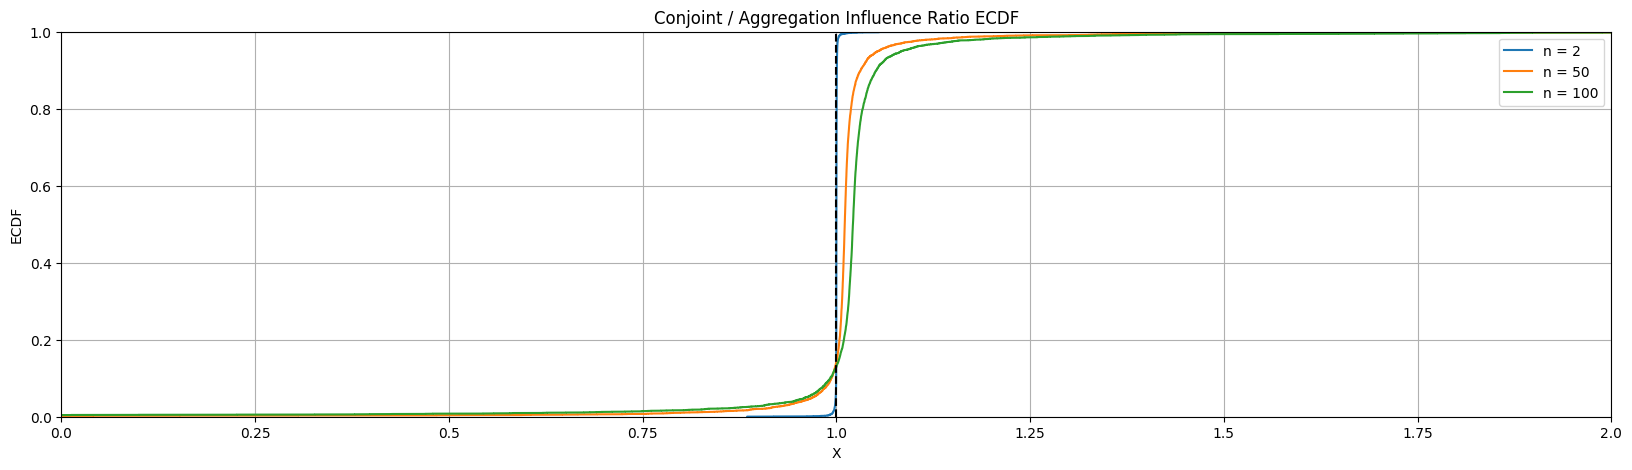

In [11]:
plt.figure(figsize=(20, 5))


xmin = -0
xmax = 2


r2 = imgn2/aggregate_ind(im, imgn2)
r2['ratio'] = r2.mean(axis=1)
ecdfr2 = ECDF(r2['ratio'])
dfr2 = pd.DataFrame({'x': ecdfr2.x, 'y': ecdfr2.y})
sns.ecdfplot(data=dfr2, x='x', label='n = 2')
plt.xlim(xmin, xmax)

r50 = imgn50/aggregate_ind(im, imgn50)
r50['ratio'] = r50.mean(axis=1)
ecdfr50 = ECDF(r50['ratio'])
dfr50 = pd.DataFrame({'x': ecdfr50.x, 'y': ecdfr50.y})
sns.ecdfplot(data=dfr50, x='x', label='n = 50')
plt.xlim(xmin, xmax)

r100 = imgn100/aggregate_ind(im, imgn100)
r100['ratio'] = r100.mean(axis=1)
ecdfr100 = ECDF(r100['ratio'])
dfr100 = pd.DataFrame({'x': ecdfr100.x, 'y': ecdfr100.y})
sns.ecdfplot(data=dfr100, x='x', label='n = 100')
plt.xlim(xmin, xmax)




plt.xlabel('X')
plt.ylabel('ECDF')
plt.title('Conjoint / Aggregation Influence Ratio ECDF')
plt.grid(True)

plt.gca().xaxis.set_major_formatter(FixedFormatter([x for x in plt.gca().get_xticks()]))


plt.axvline(x=1, color='black', linestyle='--')
plt.legend()  # Add a legend to show the labels
plt.show()


100%|██████████| 4800/4800 [03:59<00:00, 20.06it/s]


Statistically significant in rows count: 1.0


100%|██████████| 4800/4800 [04:02<00:00, 19.77it/s]


Statistically significant in rows count: 1.0


100%|██████████| 4800/4800 [04:03<00:00, 19.75it/s]


Statistically significant in rows count: 1.0


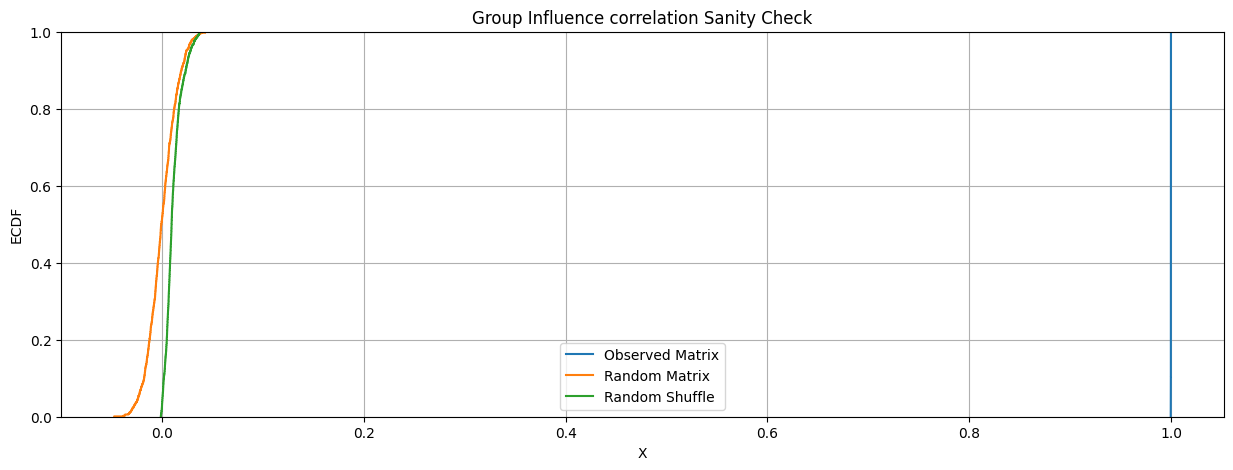

In [12]:
# SANITY CHECK



def random_gaussian_df(df):
    shape = df.shape
    random_values = np.random.normal(loc=0, scale=1, size=shape)
    random_df = pd.DataFrame(random_values, index=df.index, columns=df.columns)

    return random_df


def shuffle_dataframe(df):
    shuffled_df = df.copy()
    shuffled_df = shuffled_df.sample(frac=1, random_state=np.random.RandomState())
    return shuffled_df



plt.figure(figsize=(15, 5))
ecdfn50 = ecdf(imgn50, aggregate_ind(im, imgn50))
dfn50 = pd.DataFrame({'x': ecdfn50.x, 'y': ecdfn50.y})
sns.ecdfplot(data=dfn50, x='x', label='Observed Matrix')

ecdfn50r = ecdf(imgn50, random_gaussian_df(aggregate_ind(im, imgn50)))
dfn50r = pd.DataFrame({'x': ecdfn50r.x, 'y': ecdfn50r.y})
sns.ecdfplot(data=dfn50r, x='x', label='Random Matrix')

ecdfn50s = ecdf(imgn50, shuffle_dataframe(aggregate_ind(im, imgn50)))
dfn50s = pd.DataFrame({'x': ecdfn50s.x, 'y': ecdfn50s.y})
sns.ecdfplot(data=dfn50s, x='x', label='Random Shuffle')

plt.xlabel('X')
plt.ylabel('ECDF')
plt.title('Group Influence correlation Sanity Check')
plt.grid(True)


plt.legend()  # Add a legend to show the labels
plt.show()

